In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import precision_score,recall_score,precision_recall_curve,f1_score,fbeta_score
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.naive_bayes import BernoulliNB

In [2]:
# Data overview 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [4]:
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [6]:
trace = go.Pie(labels = train['churn'].value_counts().keys().tolist(),
               values = train['churn'].value_counts().values.tolist(),
               marker = dict(colors = ['dodgerblue','orange'])
              ,rotation = 90,
              hole = .2)
layout = go.Layout(title='Customer churn rate in training set')
data = [trace]
fig = go.Figure(data=data,layout = layout)
py.iplot(fig)

In [7]:
# exploring the features
train.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [8]:
train['churn'] = train['churn'].map(dict(yes=True,no=False))

In [9]:
train['churn'].unique()

array([False,  True])

<AxesSubplot:>

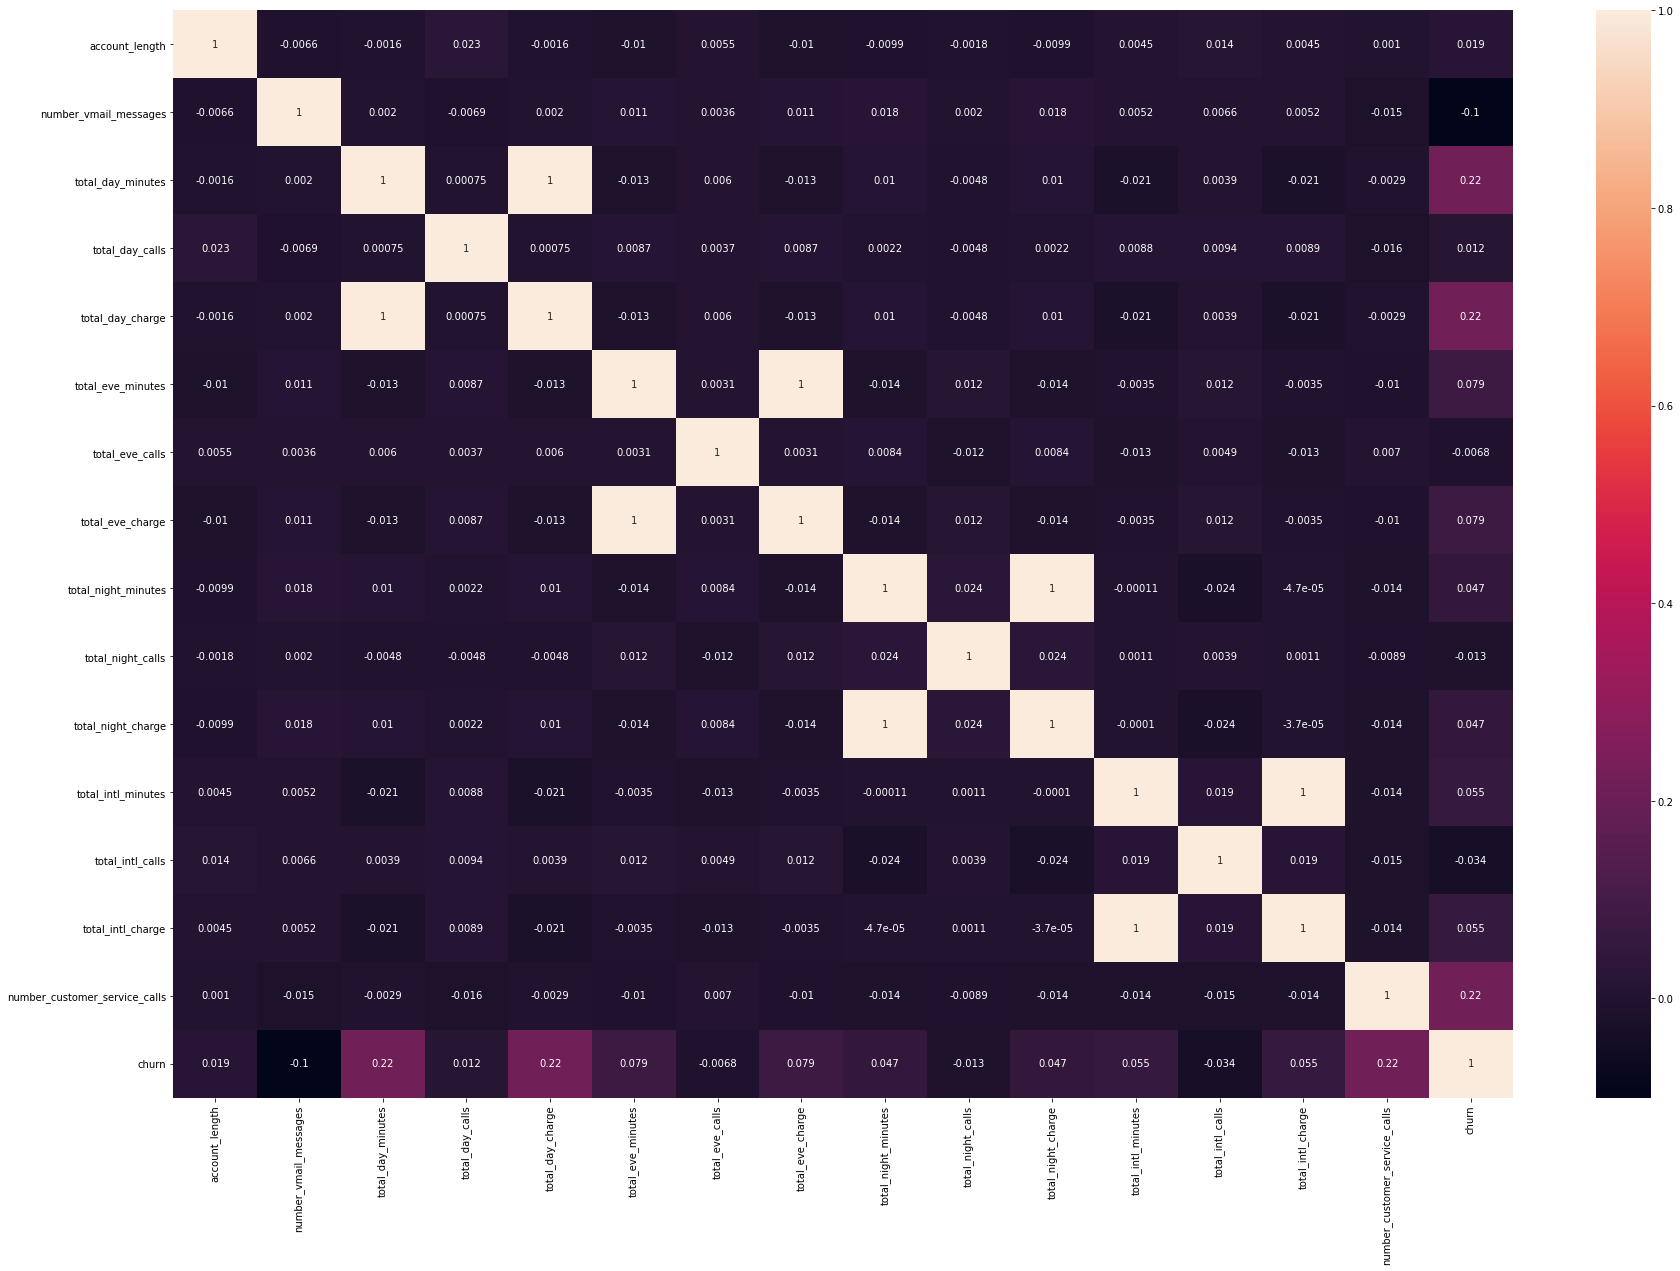

In [10]:
# examining the correlation between numeric features
plt.figure(figsize=(30,20))
sns.heatmap(train.corr(),annot = True)

In [11]:
# day charge and day minutes are the same thing because how many mintues you use , 
# the phone company will charge you correspondingly
#, so I will drop the day charge columns 
train.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [12]:
train.drop(['total_day_charge','total_eve_charge','total_night_charge', 'total_intl_charge'],axis = 1 , inplace = True)

<AxesSubplot:>

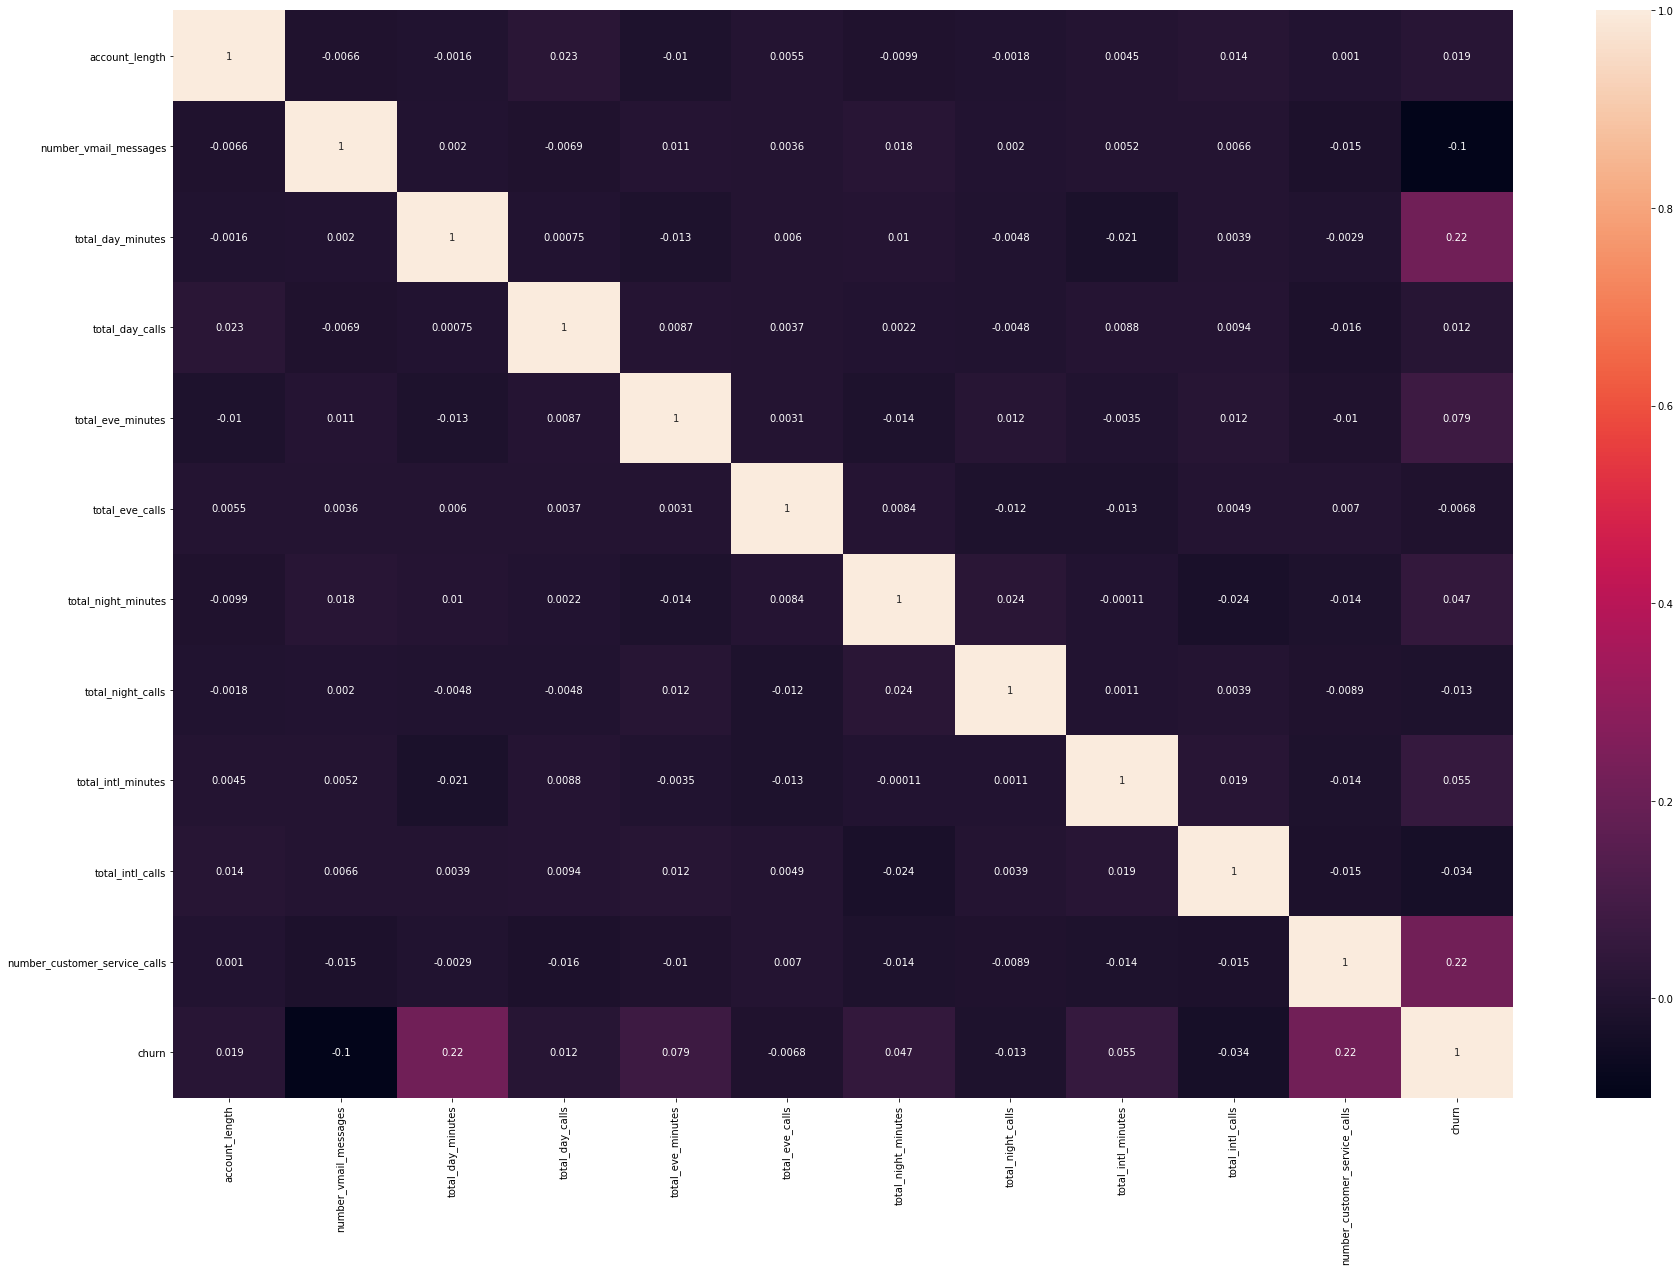

In [13]:
plt.figure(figsize=(30,20))
sns.heatmap(train.corr(),annot = True)

In [14]:
# Checking the categorical variables 
train.select_dtypes('object').columns

Index(['state', 'area_code', 'international_plan', 'voice_mail_plan'], dtype='object')

In [15]:
categ = ['area_code', 'international_plan', 'voice_mail_plan']

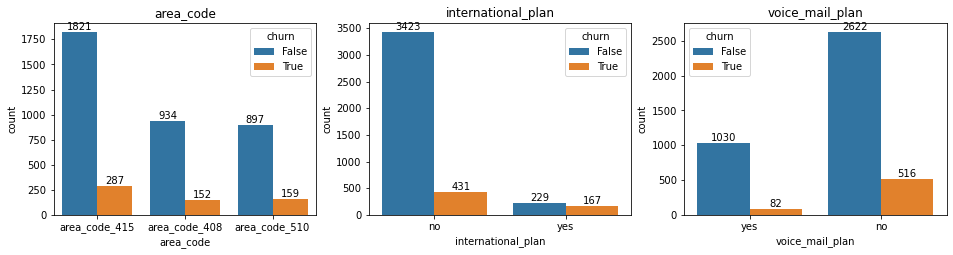

In [16]:
fig = plt.figure(figsize=[16,12])
for i, col in enumerate(categ):
    a = fig.add_subplot(3,3,i+1)
    a = sns.countplot(x = train[col],ax = a,hue = train['churn'])
    a.set_title(col)
    a.bar_label(a.containers[0])
    a.bar_label(a.containers[1])

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_eve_minutes              4250 non-null   float64
 9   total_eve_calls                4250 non-null   int64  
 10  total_night_minutes            4250 non-null   float64
 11  total_night_calls              4250 non-null   int64  
 12  total_intl_minutes             4250 non-null   f

In [18]:
num_cols = ['number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_eve_minutes', 'total_eve_calls',
       'total_night_minutes', 'total_night_calls', 'total_intl_minutes',
       'total_intl_calls', 'number_customer_service_calls']

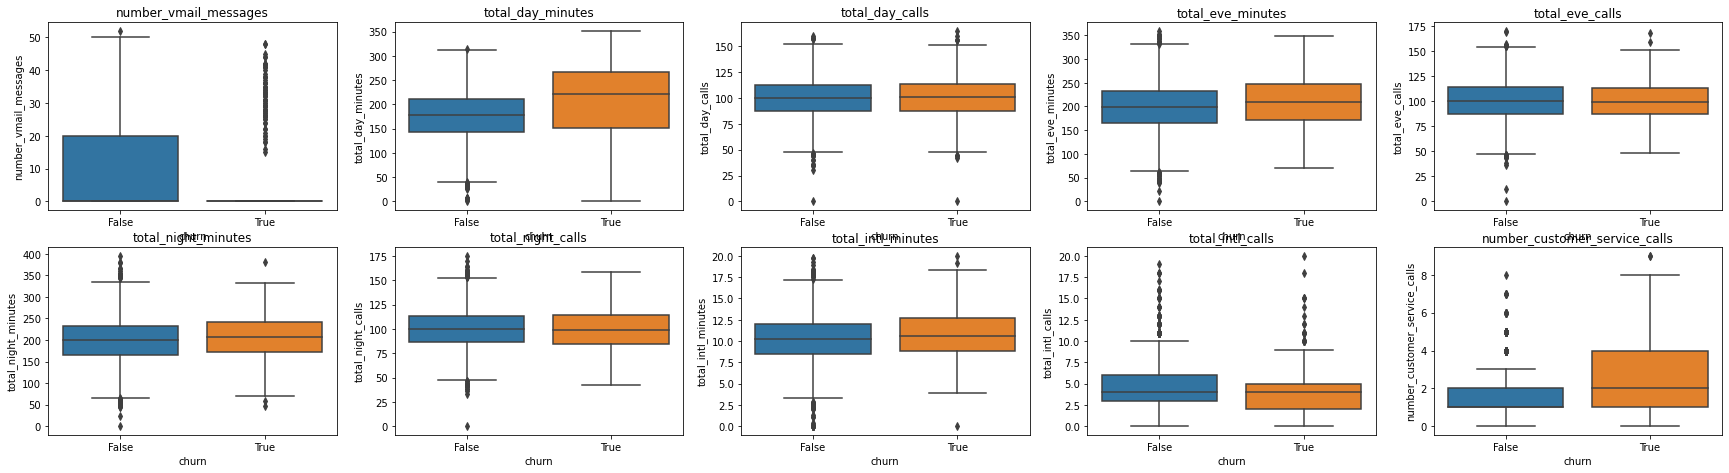

In [19]:
fig = plt.figure(figsize=[30,20])
for i , col in enumerate(num_cols):
    a = fig.add_subplot(5,5,i+1)
    a = sns.boxplot(x='churn',y=col,ax = a,data = train)
    a.set_title(col)

In [20]:
# Training variables summary 
train.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,200.173906,100.176471,200.527882,99.839529,10.256071,4.426353,1.559059
std,39.698401,13.439882,54.012373,19.850817,50.249518,19.908591,50.353548,20.093220,2.760102,2.463069,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,165.925000,87.000000,167.225000,86.000000,8.500000,3.000000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,200.700000,100.000000,200.450000,100.000000,10.300000,4.000000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,233.775000,114.000000,234.700000,113.000000,12.000000,6.000000,2.000000
max,243.000000,52.000000,351.500000,165.000000,359.300000,170.000000,395.000000,175.000000,20.000000,20.000000,9.000000


In [21]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
1,NJ,137,area_code_415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
2,OH,84,area_code_408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
3,OK,75,area_code_415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False
4,MA,121,area_code_510,no,yes,24,218.2,88,348.5,108,212.6,118,7.5,7,3,False


In [22]:
train = pd.get_dummies(train,columns=['state', 'area_code', 'international_plan', 'voice_mail_plan'],drop_first=True)

In [23]:
#Since the target variable 'churn' is very uneven, before fitting it to the machine learning models, we will first have to balance it out
# Let's try with no resample the dataset

X,y = train.drop('churn',axis=1),train['churn']
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size = 0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train_val,y_train_val,test_size = .25)

In [24]:
kf = KFold(n_splits=10,shuffle=True)

In [25]:
def make_confusion_matrix(model,threshold=0.5,kf=5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not churn', 'Churn'],
           yticklabels=['Not churn','Churn']);
    print('Recall score', np.mean(cross_val_score(model ,X_train,y_train,cv=kf,scoring='recall')))
    print('Precision score', np.mean(cross_val_score(model ,X_train,y_train,cv=kf,scoring='precision')))
    print('f1 score',np.mean(cross_val_score(model ,X_train,y_train,cv=kf,scoring='f1')))
    print('roc_auc score',np.mean(cross_val_score(model ,X_train,y_train,cv=kf,scoring='roc_auc')))
    print('accuracy score',np.mean(cross_val_score(model,X_train,y_train,cv=kf,scoring='accuracy')))
    print(classification_report(y_test,y_predict))
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [26]:
def optimal_threshold(model):

    y_score = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
    )
    optimal_idx = np.argmax(tpr-fpr)
    thres_idx = thresholds[optimal_idx]
    print(round(thres_idx,4))
    fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

In [27]:
lr = LogisticRegression(solver ='liblinear')
lr.fit(X_train,y_train)
optimal_threshold(lr)


0.1646


Recall score 0.19238095238095237
Precision score 0.5620046620046619
f1 score 0.28413719080309463
roc_auc score 0.8147563881942764
accuracy score 0.8694117647058823
              precision    recall  f1-score   support

       False       0.94      0.74      0.83       740
        True       0.29      0.71      0.41       110

    accuracy                           0.74       850
   macro avg       0.62      0.73      0.62       850
weighted avg       0.86      0.74      0.78       850



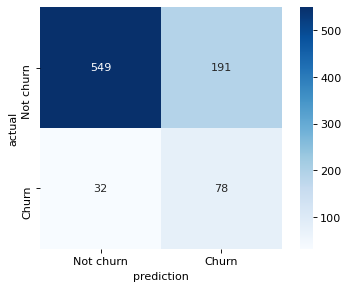

In [28]:
make_confusion_matrix(lr,threshold=0.1307)

In [29]:
# If we don't oversample the dataset, machine learning models will have a hard time classifying the correct answer 
import imblearn.over_sampling
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1:n_pos*4,0:n_neg}
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy=ratio)
X_tr_rs,y_tr_rs = ROS.fit_resample(X_train,y_train)
lr_rs = LogisticRegression(solver='liblinear')
lr_rs.fit(X_tr_rs,y_tr_rs)
optimal_threshold(lr_rs)

0.4529


Recall score 0.19238095238095237
Precision score 0.5620046620046619
f1 score 0.28413719080309463
roc_auc score 0.8147563881942764
accuracy score 0.8694117647058823
              precision    recall  f1-score   support

       False       0.95      0.68      0.79       740
        True       0.27      0.78      0.40       110

    accuracy                           0.69       850
   macro avg       0.61      0.73      0.60       850
weighted avg       0.87      0.69      0.74       850



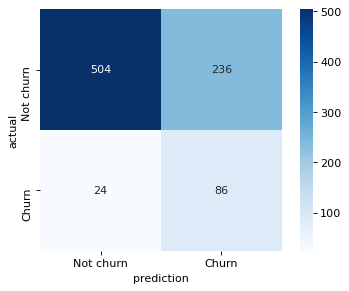

In [30]:
make_confusion_matrix(lr_rs,threshold=0.2931)

In [31]:
lr_balance = LogisticRegression(class_weight='balanced',solver = 'liblinear')
lr_balance.fit(X_train,y_train)
optimal_threshold(lr_balance)


0.4511


Recall score 0.7499378881987577
Precision score 0.34532741139107853
f1 score 0.47247477175601843
roc_auc score 0.818780297802037
accuracy score 0.7709803921568626
              precision    recall  f1-score   support

       False       0.96      0.69      0.80       740
        True       0.27      0.79      0.41       110

    accuracy                           0.70       850
   macro avg       0.62      0.74      0.60       850
weighted avg       0.87      0.70      0.75       850



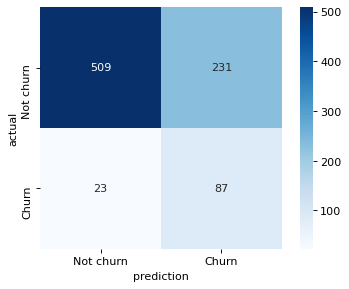

In [32]:
make_confusion_matrix(lr_balance,0.4012)

In [33]:
lr_5x = LogisticRegression(class_weight={1:5,0:1},solver = 'liblinear')
lr_5x.fit(X_train,y_train)
optimal_threshold(lr_5x)


0.5196


Recall score 0.689648033126294
Precision score 0.37655002873282145
f1 score 0.48668455012182354
roc_auc score 0.8186573185268837
accuracy score 0.8015686274509803
              precision    recall  f1-score   support

       False       0.96      0.69      0.80       740
        True       0.27      0.79      0.41       110

    accuracy                           0.70       850
   macro avg       0.62      0.74      0.60       850
weighted avg       0.87      0.70      0.75       850



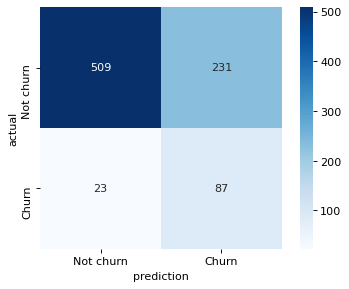

In [34]:
make_confusion_matrix(lr_5x,.3467)

In [35]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio)
X_tr_smote , y_tr_smote = smote.fit_resample(X_train,y_train)
lr_smote = LogisticRegression(solver='liblinear')
lr_smote.fit(X_tr_smote,y_tr_smote)
optimal_threshold(lr_smote)


0.2501


Recall score 0.19238095238095237
Precision score 0.5620046620046619
f1 score 0.28413719080309463
roc_auc score 0.8147563881942764
accuracy score 0.8694117647058823
              precision    recall  f1-score   support

       False       0.95      0.71      0.81       740
        True       0.28      0.76      0.41       110

    accuracy                           0.72       850
   macro avg       0.62      0.74      0.61       850
weighted avg       0.87      0.72      0.76       850



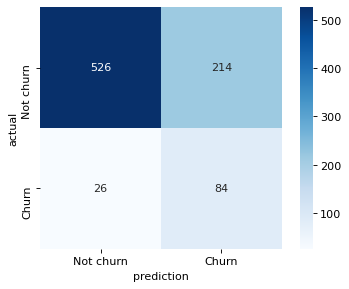

In [36]:
make_confusion_matrix(lr_smote,0.1996)

In [37]:
#random forest would perform better with oversampling, find the best number of n_estimators
scores = []
for k in tqdm(range(1,200)):
    RF = RandomForestClassifier(n_estimators=k,class_weight={1:5,0:1})
    RF.fit(X_train,y_train)
    scores.append(np.mean(cross_val_score(RF ,X_train,y_train,cv=kf,scoring='f1')))


100%|██████████| 199/199 [08:55<00:00,  2.69s/it]


In [38]:
#highest f1 score along with the index of estimators
RFmaxs = max(scores)
RF_idx = scores.index(RFmaxs)

print(RFmaxs)
print(RF_idx)

0.6709290898396755
122


In [39]:
RFS = RandomForestClassifier(n_estimators=RF_idx,class_weight={1:5,0:1})
RFS.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, n_estimators=122)

In [40]:
optimal_threshold(RFS)

0.2787


Recall score 0.4311387163561077
Precision score 0.9670536707452726
f1 score 0.6247923324532659
roc_auc score 0.9176099743366823
accuracy score 0.9184313725490197
              precision    recall  f1-score   support

       False       0.96      0.99      0.97       740
        True       0.88      0.75      0.81       110

    accuracy                           0.96       850
   macro avg       0.92      0.87      0.89       850
weighted avg       0.95      0.96      0.95       850



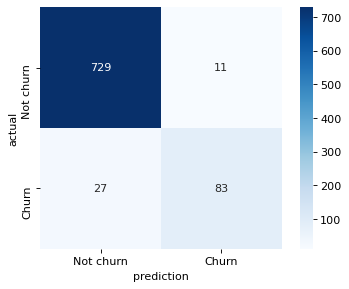

In [41]:
make_confusion_matrix(RFS,threshold=0.3571)

In [42]:
# try smote on random forest
smote_scores = []
for k in tqdm(range(1,200)):
    RF = RandomForestClassifier(n_estimators=k)
    RF.fit(X_tr_smote,y_tr_smote)
    smote_scores.append(np.mean(cross_val_score(RF ,X_train,y_train,cv=kf,scoring='f1')))


100%|██████████| 199/199 [09:53<00:00,  2.98s/it]


In [43]:
smote_RFmaxs = max(smote_scores)
smote_RF_idx = smote_scores.index(smote_RFmaxs)

print(smote_RFmaxs)
print(smote_RF_idx)

0.7186397022099442
114


In [44]:
RF_smote = RandomForestClassifier(n_estimators=190)
RF_smote.fit(X_tr_smote,y_tr_smote)
optimal_threshold(RF_smote)

0.2895


Recall score 0.5256728778467907
Precision score 0.9340318264466871
f1 score 0.6794451425851057
roc_auc score 0.9183786556783451
accuracy score 0.931764705882353
              precision    recall  f1-score   support

       False       0.96      0.90      0.93       740
        True       0.53      0.77      0.63       110

    accuracy                           0.88       850
   macro avg       0.75      0.84      0.78       850
weighted avg       0.91      0.88      0.89       850



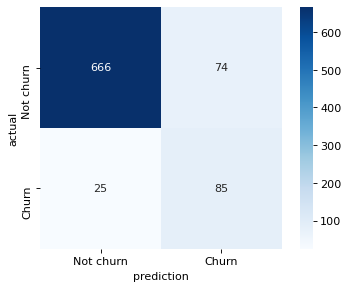

In [45]:
make_confusion_matrix(RF_smote,threshold=.3632)

In [47]:
#try knn with resampling
knn_scores = []
for k in tqdm(range(1,200)):
    knn = KNeighborsClassifier(n_neighbors=k,)
    knn.fit(X_tr_rs,y_tr_rs)
    knn_scores.append(np.mean(cross_val_score(knn ,X_train,y_train,cv=kf,scoring='f1')))

100%|██████████| 199/199 [00:39<00:00,  5.08it/s]


In [48]:
#highest f1 score along with the index of n_neighbors
knn_maxs = max(knn_scores)
knn_idx = knn_scores.index(knn_maxs)

print(knn_maxs)
print(knn_idx)

0.4336410672673379
6


In [49]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_tr_rs,y_tr_rs)
optimal_threshold(knn)

0.5


Recall score 0.23855072463768115
Precision score 0.8031824905400755
f1 score 0.36495439903973986
roc_auc score 0.6694134804119276
accuracy score 0.887843137254902
              precision    recall  f1-score   support

       False       0.91      0.83      0.87       740
        True       0.29      0.47      0.36       110

    accuracy                           0.78       850
   macro avg       0.60      0.65      0.61       850
weighted avg       0.83      0.78      0.80       850



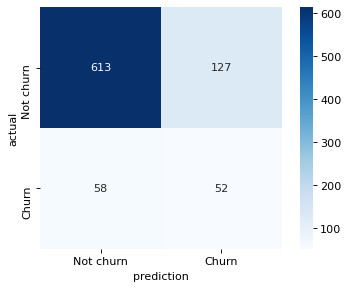

In [50]:
#knn doesn't do a great job 
make_confusion_matrix(knn)

In [51]:
# Lets try decision-tree
tree_scores = []
for k in tqdm(range(1,50)):
    D = DecisionTreeClassifier(max_depth=k)
    D.fit(X_tr_rs,y_tr_rs)
    tree_scores.append(np.mean(cross_val_score(D ,X_train,y_train,cv=kf,scoring='f1')))


100%|██████████| 49/49 [00:11<00:00,  4.40it/s]


In [52]:
tree_maxs = max(tree_scores)
tree_idx = tree_scores.index(tree_maxs)

print(knn_maxs)
print(knn_idx)

0.4336410672673379
6


In [53]:
D = DecisionTreeClassifier(max_depth=2,class_weight={1:5,0:1})
D.fit(X_train,y_train)
optimal_threshold(D)


0.838


Recall score 0.6182194616977226
Precision score 0.5731582442909501
f1 score 0.5933670806805135
roc_auc score 0.7734949890803928
accuracy score 0.8847058823529412
              precision    recall  f1-score   support

       False       0.94      0.92      0.93       740
        True       0.55      0.63      0.58       110

    accuracy                           0.88       850
   macro avg       0.75      0.78      0.76       850
weighted avg       0.89      0.88      0.89       850



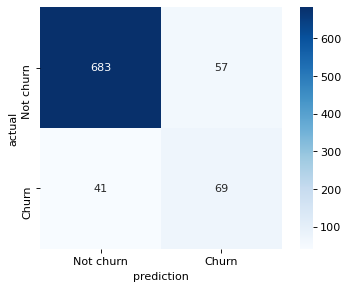

In [54]:
make_confusion_matrix(D,threshold=0.8212)

In [55]:
# Lets try Gradient Boost 
gbm = xgb.XGBClassifier(n_estimators = 20000,
                       max_death =4,
                       objective = 'binary:logistic',
                       learning_rate =.05,
                       subsample=.8,
                       min_child_weight=3,
                       colsample_bytree=.8,verbosity = 0)
eval_set = [(X_train,y_train),(X_train_val,y_train_val)]
fit_model = gbm.fit(X_tr_rs,y_tr_rs,
                   eval_set=eval_set,
                   eval_metric = 'auc',
                   early_stopping_rounds = 50,
                   verbose=False)

In [56]:
optimal_threshold(fit_model)

0.2824


Recall score 0.6205797101449275
Precision score 0.8721121098342625
f1 score 0.7245780729893584
roc_auc score 0.9048642338797619
accuracy score 0.935686274509804
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       740
        True       0.89      0.85      0.87       110

    accuracy                           0.97       850
   macro avg       0.93      0.91      0.92       850
weighted avg       0.97      0.97      0.97       850



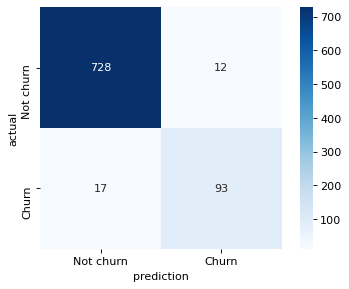

In [57]:
make_confusion_matrix(fit_model,threshold=.4163)

In [58]:
# Let's try with Naive bayes 
nb = BernoulliNB()
nb.fit(X_tr_rs,y_tr_rs)
optimal_threshold(nb)

0.3396


Recall score 0.1034368530020704
Precision score 0.4629699248120301
f1 score 0.16877159852705126
roc_auc score 0.6829838737866689
accuracy score 0.8607843137254904
              precision    recall  f1-score   support

       False       0.91      0.55      0.69       740
        True       0.17      0.64      0.27       110

    accuracy                           0.56       850
   macro avg       0.54      0.60      0.48       850
weighted avg       0.82      0.56      0.64       850



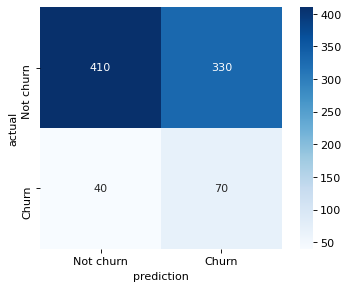

In [59]:
make_confusion_matrix(nb,threshold=.3715)

In [60]:
smote_xgb =  gbm.fit(X_tr_smote,y_tr_smote,
                   eval_set=eval_set,
                   eval_metric = 'auc',
                   early_stopping_rounds = 50,
                   verbose=False)

In [61]:
optimal_threshold(smote_xgb)

0.2637


Recall score 0.6205797101449275
Precision score 0.8721121098342625
f1 score 0.7245780729893584
roc_auc score 0.9048642338797619
accuracy score 0.935686274509804
              precision    recall  f1-score   support

       False       0.98      0.87      0.92       740
        True       0.51      0.89      0.64       110

    accuracy                           0.87       850
   macro avg       0.74      0.88      0.78       850
weighted avg       0.92      0.87      0.89       850



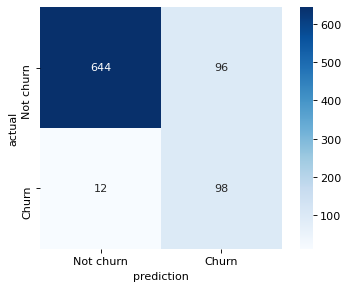

In [62]:
make_confusion_matrix(smote_xgb,.1648)

In [63]:
# Will make a grid to organize all the models that I just did 
models = {
        'Logistic Regression': LogisticRegression(class_weight={1:5,0:1},solver = 'liblinear'),
         'Random Forest':  RandomForestClassifier(n_estimators=122,class_weight={1:5,0:1}),
        'Decision Tree': DecisionTreeClassifier(max_depth=3,class_weight={1:5,0:1}),
          'Gradient Boost':xgb.XGBClassifier(n_estimators = 1000,
                       max_death =4,
                       objective = 'binary:logistic',
                       learning_rate =.05,
                       subsample=.8,
                       min_child_weight=3,
                       colsample_bytree=.8,verbosity = 0,class_weight={1:5,0:1}),
        'Naive Bayes':BernoulliNB(),
        
        }



In [64]:
for name,model in models.items():
    model.fit(X_train,y_train)
    
results = {}
kf = KFold(n_splits=10)

for name,model in models.items():
    result = cross_val_score(model,X_train,y_train,scoring='f1',cv=kf)
    results[name] = result
    
for name,result in results.items():
    print(f'{name}:{np.mean(result)}')

Logistic Regression:0.4875667943556257
Random Forest:0.6242059763978933
Decision Tree:0.5952796879881541
Gradient Boost:0.7854746391732927
Naive Bayes:0.1592494493810283


In [65]:
# Gradient Boost outperforms all the other models, so I will use xgboost
xgb = xgb.XGBClassifier(n_estimators = 1000,
                       max_death =4,
                       objective = 'binary:logistic',
                       learning_rate =.05,
                       subsample=.8,
                       min_child_weight=3,
                       colsample_bytree=.8,verbosity = 0,class_weight={1:5,0:1})

In [119]:
# Fit the model the whole training set 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [120]:
test = pd.read_csv('test.csv')
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [121]:
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [122]:
test.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [123]:
train['churn'] = train['churn'].map(dict(yes=True,no=False))
X,y = train.drop('churn',axis=1),train['churn']
test.drop(['id'],axis = 1 , inplace = True)

In [124]:
X.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3


In [125]:
test

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,GA,130,area_code_415,no,no,0,119.4,99,20.30,226.3,97,19.24,202.7,111,9.12,11.3,7,3.05,0
746,WA,73,area_code_408,no,no,0,177.2,118,30.12,270.5,84,22.99,241.8,112,10.88,12.3,2,3.32,3
747,WV,152,area_code_415,no,no,0,184.2,90,31.31,256.8,73,21.83,213.6,113,9.61,14.7,2,3.97,3
748,DC,61,area_code_415,no,no,0,140.6,89,23.90,172.8,128,14.69,212.4,97,9.56,13.6,4,3.67,1


In [126]:
t = pd.concat([X,test])

In [127]:
t.drop(['total_day_charge','total_eve_charge','total_night_charge', 'total_intl_charge'],axis = 1 , inplace = True)

In [128]:
t = pd.get_dummies(t,drop_first=True)

In [129]:
t

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes
0,107,26,161.6,123,195.5,103,254.4,103,13.7,3,...,0,0,0,0,0,0,1,0,0,1
1,137,0,243.4,114,121.2,110,162.6,104,12.2,5,...,0,0,0,0,0,0,1,0,0,0
2,84,0,299.4,71,61.9,88,196.9,89,6.6,7,...,0,0,0,0,0,0,0,0,1,0
3,75,0,166.7,113,148.3,122,186.9,121,10.1,3,...,0,0,0,0,0,0,1,0,1,0
4,121,24,218.2,88,348.5,108,212.6,118,7.5,7,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,130,0,119.4,99,226.3,97,202.7,111,11.3,7,...,0,0,0,0,0,0,1,0,0,0
746,73,0,177.2,118,270.5,84,241.8,112,12.3,2,...,0,0,1,0,0,0,0,0,0,0
747,152,0,184.2,90,256.8,73,213.6,113,14.7,2,...,0,0,0,0,1,0,1,0,0,0
748,61,0,140.6,89,172.8,128,212.4,97,13.6,4,...,0,0,0,0,0,0,1,0,0,0


In [130]:
train = t[:4250]
test = t[4250:]

In [131]:
y

0       False
1       False
2       False
3       False
4       False
        ...  
4245    False
4246    False
4247    False
4248    False
4249    False
Name: churn, Length: 4250, dtype: bool

In [132]:
xgb.fit(train,y)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight={0: 1, 1: 5},
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_death=4,
              max_delta_step=0, max_depth=6, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [176]:
train.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes
0,107,26,161.6,123,195.5,103,254.4,103,13.7,3,...,0,0,0,0,0,0,1,0,0,1
1,137,0,243.4,114,121.2,110,162.6,104,12.2,5,...,0,0,0,0,0,0,1,0,0,0
2,84,0,299.4,71,61.9,88,196.9,89,6.6,7,...,0,0,0,0,0,0,0,0,1,0
3,75,0,166.7,113,148.3,122,186.9,121,10.1,3,...,0,0,0,0,0,0,1,0,1,0
4,121,24,218.2,88,348.5,108,212.6,118,7.5,7,...,0,0,0,0,0,0,0,1,0,1


In [169]:
from xgboost import plot_importance


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

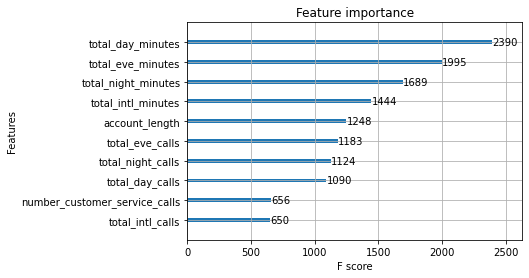

In [171]:
plot_importance(xgb,max_num_features=10)

In [133]:
test['churn'] = xgb.predict(test)

In [134]:
test.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,...,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes,churn
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,...,0,0,0,0,0,1,0,0,1,False
1,118,0,223.4,98,220.6,101,203.9,118,6.3,6,...,0,0,0,0,0,0,1,1,0,False
2,62,0,120.7,70,307.2,76,203.0,99,13.1,6,...,0,0,0,0,0,1,0,0,0,True
3,93,0,190.7,114,218.2,111,129.6,121,8.1,3,...,1,0,0,0,0,0,1,0,0,False
4,174,0,124.3,76,277.1,112,250.7,115,15.5,5,...,0,0,0,0,0,1,0,0,0,False


In [135]:
test['id'] = test.index+1

In [136]:
test.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,...,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes,churn,id
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,...,0,0,0,0,1,0,0,1,False,1
1,118,0,223.4,98,220.6,101,203.9,118,6.3,6,...,0,0,0,0,0,1,1,0,False,2
2,62,0,120.7,70,307.2,76,203.0,99,13.1,6,...,0,0,0,0,1,0,0,0,True,3
3,93,0,190.7,114,218.2,111,129.6,121,8.1,3,...,0,0,0,0,0,1,0,0,False,4
4,174,0,124.3,76,277.1,112,250.7,115,15.5,5,...,0,0,0,0,1,0,0,0,False,5


In [150]:
sub = test[['id','churn']]

In [153]:
sub['churn'] = sub['churn'].apply(lambda x:str(x))

In [159]:
sub['churn'].replace('True','yes',inplace = True)
sub['churn'].replace('False','no',inplace = True)

In [160]:
sub['churn']

0       no
1       no
2      yes
3       no
4       no
      ... 
745     no
746     no
747     no
748     no
749     no
Name: churn, Length: 750, dtype: object

In [162]:
sub.set_index('id',inplace = True)

In [163]:
sub

,churn
id,
1,no
2,no
3,yes
4,no
5,no
...,...
746,no
747,no
748,no


In [164]:
sub.to_csv('Submission')

In [174]:
optimal_threshold(xgb)

0.6931


Recall score 0.6953781512605042
Precision score 0.9099968026864579
f1 score 0.7868865519890333
roc_auc score 0.9095195773085047
accuracy score 0.9490196078431372
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       740
        True       1.00      1.00      1.00       110

    accuracy                           1.00       850
   macro avg       1.00      1.00      1.00       850
weighted avg       1.00      1.00      1.00       850



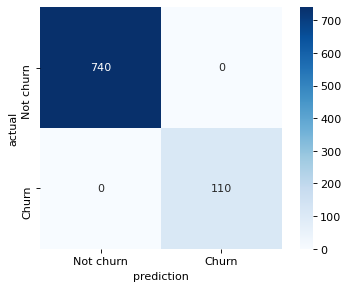

In [175]:
make_confusion_matrix(xgb,.6931,kf=10)

In [179]:
test.drop(columns=['churn','id'],axis = 1,inplace = True)

In [184]:
result_proba = xgb.predict_proba(test)

In [185]:
result_boolean2= (result_proba[:,1] > 0.6931) 

In [186]:
test['churn'] = result_boolean2

In [187]:
test.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,...,state_VT,state_WA,state_WI,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,international_plan_yes,voice_mail_plan_yes,churn
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,...,0,0,0,0,0,1,0,0,1,False
1,118,0,223.4,98,220.6,101,203.9,118,6.3,6,...,0,0,0,0,0,0,1,1,0,False
2,62,0,120.7,70,307.2,76,203.0,99,13.1,6,...,0,0,0,0,0,1,0,0,0,True
3,93,0,190.7,114,218.2,111,129.6,121,8.1,3,...,1,0,0,0,0,0,1,0,0,False
4,174,0,124.3,76,277.1,112,250.7,115,15.5,5,...,0,0,0,0,0,1,0,0,0,False


In [188]:
test['id'] = test.index+1

In [189]:
new_sub = test[['id','churn']]

In [190]:
new_sub

,id,churn
0,1,False
1,2,False
2,3,True
3,4,False
4,5,False
...,...,...
745,746,False
746,747,False
747,748,False
748,749,False


In [191]:
new_sub['churn'] = new_sub['churn'].apply(lambda x:str(x))
new_sub['churn'].replace('True','yes',inplace = True)
new_sub['churn'].replace('False','no',inplace = True)
new_sub.set_index('id',inplace = True)

In [192]:
new_sub

,churn
id,
1,no
2,no
3,yes
4,no
5,no
...,...
746,no
747,no
748,no


In [193]:
new_sub.to_csv('New Submission')